In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import scipy
from statsmodels.stats.descriptivestats import sign_test
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import summary_table
import itertools
from sklearn.linear_model import Ridge
%matplotlib inline

/home/dencerr/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
def chi2_two_sample_test(X1, X2):
    n1 = sum(X1)
    n2 = sum(X2)
    k1 = np.sqrt(n1/n2)
    k2 = np.sqrt(n2/n1)
    z = 0.
    for i in range(len(X1)):
        z+=(k1*X2[i] - k2*X1[i])**2/(X2[i]+X1[i])
    if n1 != n2:
        p_val = 1 - stats.chi2(len(X1) - 1).cdf(z)
    else:
        p_val = 1 - stats.chi2(len(X1)).cdf(z)
    return (z, p_val)

In [3]:
def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [4]:
def disp_analyses_tabl(*args):
    tabl = np.zeros((3, 3))
    k = len(args) #num_of_groups
    n = sum([len(args[i]) for i in range(k)])# general num of el
    full_sample = np.concatenate([args[i] for i in range(k)], axis = 0)
    n_i = [len(args[i]) for i in range(k)]
    v_i = [np.var(args[i]) for i in range(k)]
    m_i = [np.mean(args[i]) for i in range(k)]
    m = np.mean(full_sample)
    d_vn_gr = np.average(v_i, weights=n_i)
    tabl[1][0] = d_vn_gr
    tabl[1][1] = n - k
    tabl[1][2] = d_vn_gr*(n/(n-k))
    d_ob = np.var(full_sample)
    tabl[2][0] = d_ob
    tabl[2][1] = n - 1
    tabl[2][2] = d_ob*(n/(n-1))
    d_m_gr = np.average(np.array([m_i[i] - m for i in range(k)])**2, weights=n_i)
    tabl[0][0] = d_m_gr
    tabl[0][1] = k - 1
    tabl[0][2] = d_m_gr*(n/(k-1))
    return tabl

In [5]:
def count_hi_stat_norm(hist, mean, std, num_el):
    # добавлены в параметры в norm
    observed_frequences = hist[0] * (hist[1][1] - hist[1][0]) * num_el
    expected_frequences = stats.norm(mean, std).cdf(hist[1])
    expected_frequences = [expected_frequences[i + 1] - expected_frequences[i] for i in range(len(hist[1]) - 1)]
    print(expected_frequences)
    expected_frequences = np.array(expected_frequences)*num_el
    return stats.chisquare(observed_frequences, expected_frequences, ddof = 2)

In [6]:
def emp_func_distr(X):
    emp_func = np.zeros((len(X),2))
    for i in range(len(X)):
        emp_func[i][0] = X[i]
        emp_func[i][1] = sum(X<X[i])
    emp_func[:,1] = emp_func[:,1]/len(X)
    emp_func = np.array(sorted(emp_func.tolist(), key = lambda x: x[0]))
    return emp_func

In [7]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [8]:
def var_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    v = np.var(a)
    return v, (n-1)*v/scipy.stats.chi2.ppf((1 - confidence) / 2., n-1), (n-1)*v/scipy.stats.chi2.ppf(1 - (1 - confidence) / 2., n-1)

In [9]:
def diff_mean_confidence_interval(X1, X2, confidence=0.95):
    X1 = 1.0 * np.array(X1)
    X2 = 1.0 * np.array(X2)
    n = len(X1)
    m1, se1 = np.mean(X1), scipy.stats.sem(X1)
    m2, se2 = np.mean(X2), scipy.stats.sem(X2)
    m = m1 - m2
    se = np.sqrt((se1**2 + se2**2)/2)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., 2*(n-1)) * (2./n)**(0.5)
    return m, m-h, m+h

In [10]:
def diff_var_confidence_interval(X1, X2, confidence=0.95):
    alpha = 1 - confidence
    X1 = 1.0 * np.array(X1)
    X2 = 1.0 * np.array(X2)
    n = len(X1)
    v1 = np.var(X1)
    v2 = np.var(X2)
    v = v1/v2
    return v, v*stats.f.ppf(alpha/2, dfn = n-1, dfd = n-1), v*stats.f.ppf(1 - alpha/2, dfn = n-1, dfd = n-1)

In [11]:
data = pd.read_excel('data_matstat_K5.xls', sheet_name= None)

In [12]:
df1 = data['A - aaup']
df1['logA6'] = np.log(df1['A6'])
df1['logA7'] = np.log(df1['A7'])
df1.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A13,A14,A15,A16,A17,A18,A19,A20,logA6,logA7
0,1061,Alaska Pacific University,AK,IIB,454,382,362,382,N,567,...,487,N,6,11,9,4,32,N,5.945421,5.891644
1,1063,Univ.Alaska-Fairbanks,AK,I,686,560,432,508,Y,914,...,677,Y,74,125,118,40,404,Y,6.327937,6.068426
2,1065,Univ.Alaska-Southeast,AK,IIA,533,494,329,415,N,716,...,559,Y,9,26,20,9,70,N,6.202536,5.796058
3,11462,Univ.Alaska-Anchorage,AK,IIA,612,507,414,498,Y,825,...,670,Y,115,124,101,21,392,Y,6.228511,6.025866
4,1002,Alabama Agri.&Mech. Univ.,AL,IIA,442,369,310,350,N,530,...,423,N,59,77,102,24,262,N,5.910797,5.736572


In [13]:
n = len(df1)

In [14]:
df1.shape

(1073, 22)

In [15]:
df1['logA7'].std()

0.15115982983682028

In [16]:
stats.skew(df1['logA7'])

-0.03016687360999614

In [17]:
stats.kurtosis(df1['logA7'])

0.09497212376787978

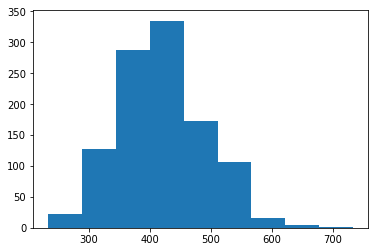

In [18]:
h = plt.hist(df1['A6'], bins = 9)

In [19]:
stats.skew(h[0])

0.6654428037521204

In [20]:
stats.kurtosis(h[0])

-0.9574269789288956

In [21]:
stats.hmean([1,1])

1.0

0.46930545049048894 1.3670927198713212
0.42308485520054867 1.4523769233727097
0.6001984537806413 1.0139188897117968
0.5484489977799368 1.3213709473441793
0.6100180378149573 1.2014322531405575
0.571051734337231 1.2393058058810997
0.6229791971017091 1.124491034608127
0.6306318849192537 1.1529533996277392
0.6096182580680355 1.1839330450036538
0.5846350044826102 1.2274758652760631
0.6065744288419234 1.1441398227600572
0.6148936477799638 1.2014511925922153
0.6201084262141897 1.1613731206887685
0.6342318170010052 1.0859837264990517
0.6351841686140337 1.1464925636595547
0.6411183427539732 1.09594781910284


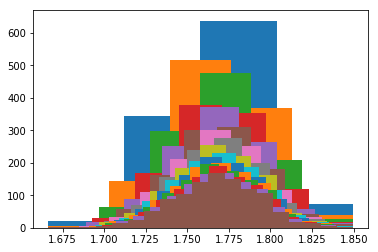

In [22]:
st = []
for i in range(4,20):
    h = plt.hist(np.log(df1['logA7']), bins = i)
    sk = stats.skew(h[0])
    kurt = abs(stats.kurtosis(h[0]))
    print(sk, kurt)
    #print(stats.hmean(sk,kurt))
    st.append((i, stats.hmean((sk,kurt))))

In [23]:
st

[(4, 0.6987417817292556),
 (5, 0.655282541443442),
 (6, 0.754037557823758),
 (7, 0.7751597405474632),
 (8, 0.8091807424004044),
 (9, 0.7818430493428956),
 (10, 0.8017699062064063),
 (11, 0.8153119247291545),
 (12, 0.8048247065230046),
 (13, 0.7920325074740446),
 (14, 0.7928260809791605),
 (15, 0.813463049550919),
 (16, 0.8085149794223541),
 (17, 0.8007896855641841),
 (18, 0.817470321836634),
 (19, 0.8089873200649708)]

In [24]:
sorted(st, key = lambda x: x[1])

[(5, 0.655282541443442),
 (4, 0.6987417817292556),
 (6, 0.754037557823758),
 (7, 0.7751597405474632),
 (9, 0.7818430493428956),
 (13, 0.7920325074740446),
 (14, 0.7928260809791605),
 (17, 0.8007896855641841),
 (10, 0.8017699062064063),
 (12, 0.8048247065230046),
 (16, 0.8085149794223541),
 (19, 0.8089873200649708),
 (8, 0.8091807424004044),
 (15, 0.813463049550919),
 (11, 0.8153119247291545),
 (18, 0.817470321836634)]

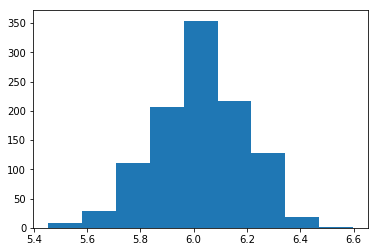

In [25]:
h = plt.hist(df1['logA6'], bins = 9)

In [26]:
h[1][1] - h[1][0]

0.12686939850321632

In [27]:
h[1]

array([5.45532112, 5.58219051, 5.70905991, 5.83592931, 5.96279871,
       6.08966811, 6.21653751, 6.3434069 , 6.4702763 , 6.5971457 ])

In [28]:
h[0]

array([  8.,  28., 111., 206., 354., 217., 128.,  19.,   2.])

In [29]:
h[0]/len(df1)

array([0.00745573, 0.02609506, 0.10344828, 0.19198509, 0.32991612,
       0.20223672, 0.11929171, 0.01770736, 0.00186393])

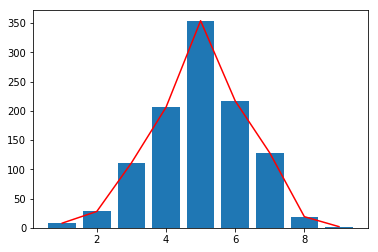

In [30]:
plt.bar(list(range(1,10)), h[0])
plt.plot(list(range(1,10)), h[0], color='red')
plt.savefig('bdz1.png')

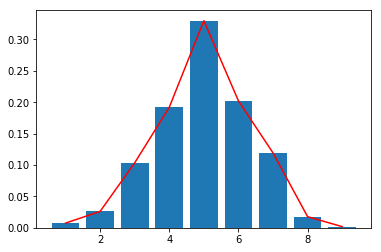

In [31]:
plt.bar(list(range(1,10)), h[0]/len(df1))
plt.plot(list(range(1,10)), h[0]/len(df1), color='red')
plt.savefig('bdz2.png')

In [32]:
h_cumm = np.ones_like(h[0]) 
h_cumm[0] = h[0][0]
for i in range(1, len(h[0])):
    h_cumm[i] = h_cumm[i-1]+h[0][i]

In [33]:
h_cumm

array([   8.,   36.,  147.,  353.,  707.,  924., 1052., 1071., 1073.])

In [34]:
h_cumm/len(df1)

array([0.00745573, 0.03355079, 0.13699907, 0.32898416, 0.65890028,
       0.861137  , 0.9804287 , 0.99813607, 1.        ])

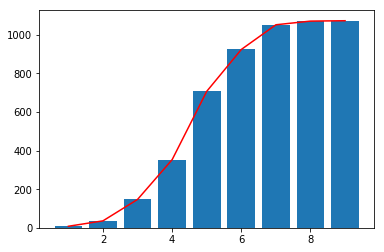

In [35]:
plt.bar(list(range(1,10)), h_cumm)
plt.plot(list(range(1,10)), h_cumm, color='red')
plt.savefig('bdz3.png')

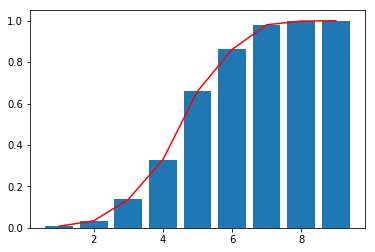

In [36]:
plt.bar(list(range(1,10)), h_cumm/len(df1))
plt.plot(list(range(1,10)), h_cumm/len(df1), color='red')
plt.savefig('bdz4.png')

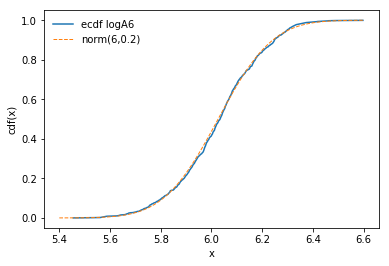

In [37]:
ecdf = emp_func_distr(df1['logA6'])
x = np.linspace(5.4,6.6,100)
plt.plot(ecdf[:,0], ecdf[:,1], label = 'ecdf logA6')
plt.plot(x, stats.norm(df1['logA6'].mean(),df1['logA6'].std()).cdf(x), linestyle='dashed', linewidth = 1, label = 'norm(6,0.2)')
plt.xlabel('x')
plt.ylabel('cdf(x)')
plt.legend(loc='best', frameon=False)
plt.savefig('bdz5.png')

In [38]:
mean_confidence_interval(df1['logA6'], 0.9)

(6.026278483963737, 6.0178072087410435, 6.034749759186431)

In [39]:
var_confidence_interval(df1['logA6'], 0.95)

(0.028384870810484925, 0.030949901412613598, 0.02612720499780913)

(array([  2.,   7.,  43., 138., 236., 301., 225.,  89.,  26.,   6.]),
 array([5.29330482, 5.39958511, 5.50586539, 5.61214568, 5.71842596,
        5.82470624, 5.93098653, 6.03726681, 6.14354709, 6.24982738,
        6.35610766]),
 <a list of 10 Patch objects>)

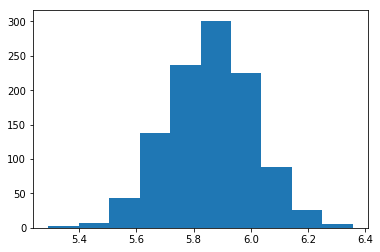

In [40]:
plt.hist(np.log(df1['A7']))

In [41]:
stats.kstest(df1['logA7'], 'norm', args=(df1['logA7'].mean(), df1['logA7'].std()))

KstestResult(statistic=0.015949506820710446, pvalue=0.9477440999310549)

In [42]:
diff_mean_confidence_interval(df1['logA6'], df1['logA7'], 0.9)

(0.16531000714002442, 0.16496278512463172, 0.1656572291554171)

In [43]:
diff_var_confidence_interval(df1['logA6'], df1['logA7'], 0.9)

(1.2434234966036897, 1.1245112033541362, 1.374910260826668)

# 3

In [44]:
m0 = 6.026
z = (np.mean(df1['logA6']) - m0)/(np.std(df1['logA6'])/(len(df1)**(0.5)))

In [45]:
stats.ttest_1samp(df1['logA6'], m0)

Ttest_1sampResult(statistic=0.05411954335115425, pvalue=0.9568500054878557)

In [46]:
np.mean(df1['logA6'])

6.026278483963744

In [47]:
df1['logA6'].std()

0.16855666475920913

In [48]:
sigma = 0.163
st = (n-1)*df1['logA6'].var()/sigma**2
print(st)
p1 = stats.chi2.cdf(st, n-1)
p2 = 1 - p1
print(2*min(p1, p2))

1146.3346900391548
0.11318754889104654


In [49]:
stats.ttest_ind(df1['logA6'], df1['logA7'])

Ttest_indResult(statistic=23.917015180946432, pvalue=2.9511421306442945e-112)

In [50]:
F = df1['logA6'].var()/df1['logA7'].var()
print(F)
p1 = stats.f.cdf(F, dfn = n-1, dfd = n-1)
p2 = 1 - p1
print(2*min(p1, p2))

1.2434234966036906
0.0003676021357443826


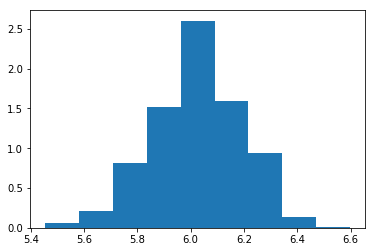

In [51]:
h = plt.hist(df1['logA6'], bins = 9, density=True)

In [52]:
count_hi_stat_norm(h, df1['logA6'].mean(), df1['logA6'].std(), n)

[0.003858312989476474, 0.025708857718157133, 0.09946793726739593, 0.22384451355586465, 0.29333621494917594, 0.22393048857647102, 0.09954441541136316, 0.0257385475234998, 0.0038642638929429207]


Power_divergenceResult(statistic=23.794675758200825, pvalue=0.0005696721861510937)

In [53]:
stats.kstest(df1['logA6'], 'norm', args=(df1['logA6'].mean(), df1['logA6'].std()))

KstestResult(statistic=0.02886130671637016, pvalue=0.3283675882338948)

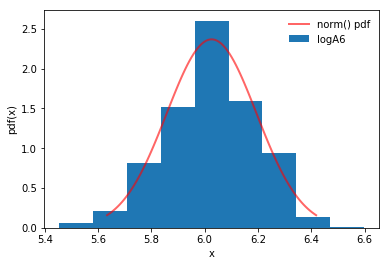

In [54]:

x = np.linspace(stats.norm(df1['logA6'].mean(), df1['logA6'].std()).ppf(0.01),
               stats.norm(df1['logA6'].mean(), df1['logA6'].std()).ppf(0.99), 100)
fig, ax = plt.subplots(1, 1)
ax.plot(x, stats.norm(df1['logA6'].mean(), df1['logA6'].std()).pdf(x),
          'r-', lw=2, alpha=0.6, label='norm() pdf')
ax.hist(df1['logA6'], bins = 9, density=True)
ax.legend(loc='best', frameon=False)
ax.set_xlabel('x')
ax.set_ylabel('pdf(x)')
plt.savefig('bdz6.png')
plt.show()

In [14]:
def harke_berr_test(X):
    z = (stats.skew(X)/np.sqrt(6./len(X)))**2 + (stats.kurtosis(X)/np.sqrt(24./len(X)))**2
    p_val = 1 - stats.chi2.cdf(z, 2)
    return(z, p_val)

In [56]:
harke_berr_test(h[0])

(0.9274274560998639, 0.6289435776025252)

# 5

In [57]:
sign_test((df1['logA6'] - (df1['logA6'].mean() - df1['logA7'].mean())) - df1['logA7'])

(-9.5, 0.5826785482680464)

In [15]:
df1['logA6_shift'] = df1['logA6'] - (df1['logA6'].mean() - df1['logA7'].mean())

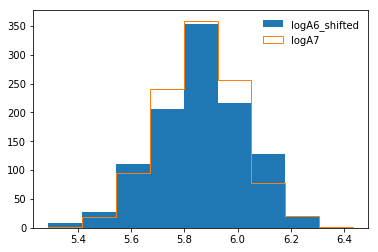

In [59]:
n_bins = 9
fig, ax = plt.subplots(1, 1)
h1 = ax.hist(df1['logA6_shift'], bins = n_bins, density=False, label = 'logA6_shifted')
h2 = ax.hist(df1['logA7'], bins = n_bins, density=False, histtype = 'step', range = (min(h1[1]), max(h1[1])), label = 'logA7')
ax.legend(loc='best', frameon=False)
plt.savefig('bdz7.png')
plt.show()

In [60]:
z = np.sum((h1[0] - h2[0])/(h1[0] + h2[0])) * n

In [61]:
z

959.5235104712082

In [62]:
1 - stats.chi2.cdf(z, n_bins - 1)

0.0

In [63]:
h2[0]/n

array([0.00186393, 0.01770736, 0.08853681, 0.22367195, 0.33457596,
       0.23951538, 0.07269338, 0.0195713 , 0.00186393])

# 6

In [13]:
cr_tab = pd.crosstab(df1['A4'], df1['A14'],  margins=True)
cr_tab_val = cr_tab.values
cr_tab

NameError: name 'df1' is not defined

In [14]:
cr_tab.columns

NameError: name 'cr_tab' is not defined

In [11]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(cr_tab)
k1 = cr_tab.shape[0]
k2 = cr_tab.shape[1]
n = np.sum(np.sum(cr_tab,axis=1))
round(np.sqrt(chi2 / (n*(min(k1, k2) - 1))), 4)

NameError: name 'cr_tab' is not defined

In [12]:
chi2

NameError: name 'chi2' is not defined

In [68]:
p

1.5946937132255872e-51

In [69]:
ex

array([[  99.31034483,   80.68965517,  180.        ],
       [ 198.06896552,  160.93103448,  359.        ],
       [ 294.62068966,  239.37931034,  534.        ],
       [ 592.        ,  481.        , 1073.        ]])

# 7

In [70]:
un_gr = np.unique(df1['A4'])
un_gr

array(['I', 'IIA', 'IIB'], dtype=object)

In [71]:
X = []
for gr in un_gr:
    X.append(df1[df1['A4'] == gr]['logA6'])

In [72]:
tabl = disp_analyses_tabl(*X)
tabl

array([[8.61092113e-03, 2.00000000e+00, 4.61975919e+00],
       [1.97739497e-02, 1.07000000e+03, 1.98293907e-02],
       [2.83848708e-02, 1.07200000e+03, 2.84113492e-02]])

In [73]:
tabl[0][0]+tabl[1][0]

0.028384870810485303

In [74]:
tabl[0][0]/tabl[2][0]

0.3033630551725796

In [75]:
np.sqrt(tabl[0][0]/tabl[2][0])

0.5507840367808235

In [76]:
stats.f_oneway(*X)

F_onewayResult(statistic=232.9753478083571, pvalue=1.0197153489530118e-84)

In [77]:
stats.bartlett(*X)

BartlettResult(statistic=40.6781591321551, pvalue=1.4684189398806075e-09)

# 8

In [78]:
df1.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,A14,A15,A16,A17,A18,A19,A20,logA6,logA7,logA6_shift
0,1061,Alaska Pacific University,AK,IIB,454,382,362,382,N,567,...,N,6,11,9,4,32,N,5.945421,5.891644,5.780111
1,1063,Univ.Alaska-Fairbanks,AK,I,686,560,432,508,Y,914,...,Y,74,125,118,40,404,Y,6.327937,6.068426,6.162627
2,1065,Univ.Alaska-Southeast,AK,IIA,533,494,329,415,N,716,...,Y,9,26,20,9,70,N,6.202536,5.796058,6.037226
3,11462,Univ.Alaska-Anchorage,AK,IIA,612,507,414,498,Y,825,...,Y,115,124,101,21,392,Y,6.228511,6.025866,6.063201
4,1002,Alabama Agri.&Mech. Univ.,AL,IIA,442,369,310,350,N,530,...,N,59,77,102,24,262,N,5.910797,5.736572,5.745487


In [83]:
r_p = stats.pearsonr(df1['logA6'], df1['logA7'])
r_p

(0.9415911240358823, 0.0)

In [88]:
r_p = stats.spearmanr(df1['logA6'], df1['logA7'])
r_p

SpearmanrResult(correlation=0.9424893824769129, pvalue=0.0)

In [90]:
tay = stats.kendalltau(df1['logA6'], df1['logA7'])
tay

KendalltauResult(correlation=0.8019916322882887, pvalue=0.0)

In [82]:
pearsonr_ci(df1['logA6'], df1['logA7'], 0.1)

(0.9415911240358823, 0.0, 0.935610403438341, 0.9470315369972134)

In [89]:
st = r_p[0]*(n-2)**(0.5)/(1 - r_p[0]**2)**(0.5)
st

184.69356754877307

In [91]:
st = tay[0]/((2*(2*n+5))/(9*n*(n-1)))**(0.5)
st

78.77962450449527

In [92]:
df1.corr('kendall')

,A1,A5,A6,A7,A8,A10,A11,A12,A13,A15,A16,A17,A18,A19,logA6,logA7,logA6_shift
A1,1.000000,-0.033328,-0.031947,-0.036907,-0.042877,-0.027034,-0.017398,-0.017096,-0.030557,-0.038898,-0.006683,-0.022305,0.028076,-0.023486,-0.031947,-0.036907,-0.031947
A5,-0.033328,1.000000,0.820784,0.765362,0.840527,0.907753,0.789869,0.739296,0.810051,0.503811,0.502880,0.441081,0.065927,0.502755,0.820784,0.765362,0.820784
A6,-0.031947,0.820784,1.000000,0.801992,0.812955,0.801450,0.880354,0.770205,0.786527,0.469794,0.478713,0.420215,0.065500,0.476927,1.000000,0.801992,1.000000
A7,-0.036907,0.765362,0.801992,1.000000,0.786878,0.748381,0.768683,0.860713,0.760740,0.503213,0.499595,0.449270,0.081404,0.507340,0.801992,1.000000,0.801992
A8,-0.042877,0.840527,0.812955,0.786878,1.000000,0.830287,0.797904,0.766454,0.908262,0.541015,0.486880,0.395593,0.012637,0.486615,0.812955,0.786878,0.812955
A10,-0.027034,0.907753,0.801450,0.748381,0.830287,1.000000,0.824330,0.763876,0.849436,0.492106,0.484654,0.416442,0.048965,0.482644,0.801450,0.748381,0.801450
A11,-0.017398,0.789869,0.880354,0.768683,0.797904,0.824330,1.000000,0.808098,0.828184,0.461491,0.459891,0.395127,0.047472,0.457976,0.880354,0.768683,0.880354
A12,-0.017096,0.739296,0.770205,0.860713,0.766454,0.763876,0.808098,1.000000,0.796502,0.500360,0.489888,0.430730,0.072563,0.496621,0.770205,0.860713,0.770205
A13,-0.030557,0.810051,0.786527,0.760740,0.908262,0.849436,0.828184,0.796502,1.000000,0.528407,0.472121,0.379061,0.003641,0.471186,0.786527,0.760740,0.786527
A15,-0.038898,0.503811,0.469794,0.503213,0.541015,0.492106,0.461491,0.500360,0.528407,1.000000,0.699714,0.640821,0.237074,0.797453,0.469794,0.503213,0.469794


In [39]:
def kendall_w(expt_ratings):
    if expt_ratings.ndim!=2:
        raise 'ratings matrix must be 2-dimensional'
    m = expt_ratings.shape[0] #raters
    n = expt_ratings.shape[1] # items rated
    denom = m**2*(n**3-n)
    rating_sums = np.sum(expt_ratings, axis=0)
    S = len(rating_sums)*np.var(rating_sums)
    return 12*S/denom

In [42]:
expt_ratings.rank(axis=1).values

array([[ 330.5, 1045.5,  909.5, ...,  335. ,  158. ,  498.5],
       [ 625. ,  993. ,  350. , ...,  432. ,   78.5,  711.5],
       [ 373.5,  860.5,  537.5, ...,  378.5,   83. ,  680.5]])

In [40]:
expt_ratings = df1[['A6', 'A7', 'A8']].T
k_w = kendall_w(expt_ratings.rank(axis=1).values)
k_w

0.9625150602590388

In [134]:
st = k_w*expt_ratings.shape[0]*(expt_ratings.shape[1]-1)
st

1591.9743709226466

In [135]:
1 - stats.chi2.cdf(st, expt_ratings.shape[1]-1)

0.0

# 9.1

In [66]:
df1[['A16', 'A11']].describe()

,A16,A11
count,1073.000000,1073.000000
mean,77.666356,528.720410
std,90.997184,95.519251
min,6.000000,295.000000
25%,21.000000,462.000000
50%,43.000000,522.000000
75%,101.000000,587.000000
max,721.000000,909.000000


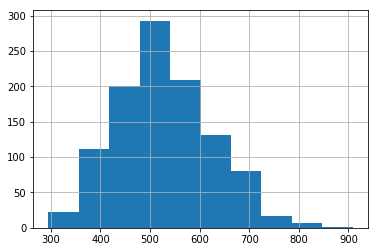

In [67]:
df1['A11'].hist()

In [14]:
df1['A11'] = np.log(df1['A11'])
df1['A16'] = np.log(df1['A16'])

In [15]:
model = sm.OLS(df1['A11'], sm.add_constant(df1['A16']))
results = model.fit()

/home/dencerr/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [16]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    A11   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     675.8
Date:                Mon, 09 Dec 2019   Prob (F-statistic):          6.72e-116
Time:                        22:28:33   Log-Likelihood:                 568.81
No. Observations:                1073   AIC:                            -1134.
Df Residuals:                    1071   BIC:                            -1124.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8168      0.017    334.791      0.0

In [101]:
results.pvalues

const     0.000000e+00
A16      6.716609e-116
dtype: float64

In [102]:
results.params

const    5.816814
A16      0.113831
dtype: float64

In [103]:
results.tvalues

const    334.790557
A16       25.995635
dtype: float64

In [104]:
def regr_analyses_tab(res):
    tabl = np.zeros((3,3))
    n = res.nobs
    tabl[0][2] = res.mse_model 
    tabl[1][2] = res.mse_resid
    tabl[2][2] = res.mse_total
    tabl[0][1] = res.df_model
    tabl[1][1] = res.df_resid
    tabl[2][1] = res.nobs - 1
    tabl[0][0] = res.mse_model * res.df_model / n
    tabl[1][0] = res.mse_resid * res.df_resid / n
    tabl[2][0] = res.mse_total * (res.nobs - 1) / n
    
    return tabl

In [105]:
regr_analyses_tab(results)

array([[1.27964356e-02, 1.00000000e+00, 1.37305754e+01],
       [2.02804519e-02, 1.07100000e+03, 2.03183239e-02],
       [3.30768875e-02, 1.07200000e+03, 3.31077428e-02]])

In [106]:
np.sqrt(results.rsquared)

0.6219882623956638

In [107]:
results.conf_int(0.1)

,0,1
const,5.788210,5.845417
A16,0.106622,0.121039


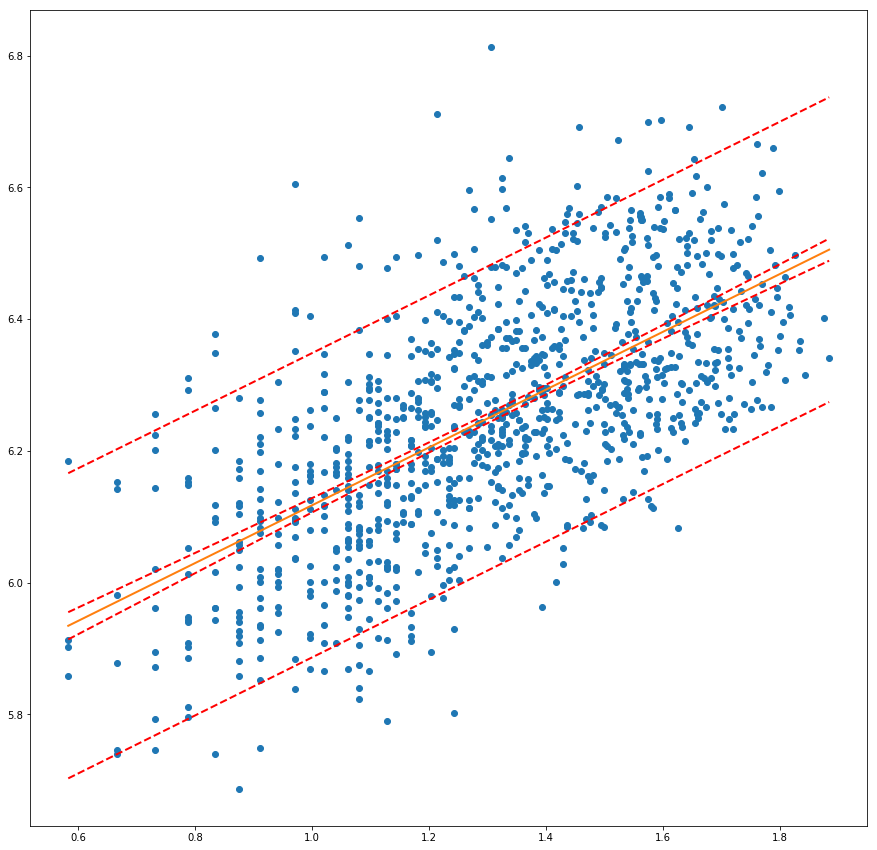

In [74]:
st, data, ss2 = summary_table(results, alpha=0.1)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T

plt.figure(figsize = (15,15))
plt.plot(df1['A16'], df1['A11'], 'o')
lists = np.array(sorted(zip(*[df1['A16'], fittedvalues])))
new_x, new_y = lists[:,0], lists[:,1]
plt.plot(new_x, new_y, '-', lw=2)

lists = np.array(sorted(zip(*[df1['A16'], predict_ci_low])))
new_x, new_y = lists[:,0], lists[:,1]
plt.plot(new_x, new_y, 'r--', lw=2)

lists = np.array(sorted(zip(*[df1['A16'], predict_ci_upp])))
new_x, new_y = lists[:,0], lists[:,1]
plt.plot(new_x, new_y, 'r--', lw=2)

lists = np.array(sorted(zip(*[df1['A16'], predict_mean_ci_low])))
new_x, new_y = lists[:,0], lists[:,1]
plt.plot(new_x, new_y, 'r--', lw=2)

lists = np.array(sorted(zip(*[df1['A16'], predict_mean_ci_upp])))
new_x, new_y = lists[:,0], lists[:,1]
plt.plot(new_x, new_y, 'r--', lw=2)

plt.show()

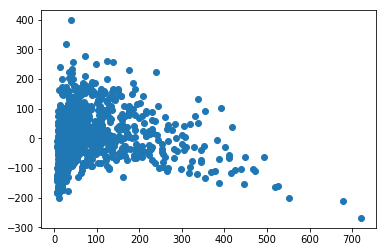

In [18]:
plt.scatter(df1['A16'], df1['A11'] - results.predict(sm.add_constant(df1['A16'])))

(array([  9.,  51., 179., 281., 259., 177.,  85.,  25.,   4.,   3.]),
 array([-0.40920228, -0.31071967, -0.21223706, -0.11375444, -0.01527183,
         0.08321078,  0.1816934 ,  0.28017601,  0.37865862,  0.47714124,
         0.57562385]),
 <a list of 10 Patch objects>)

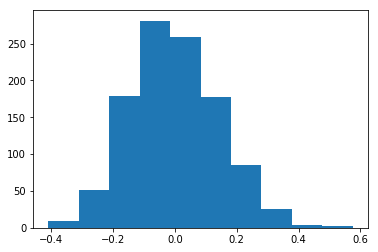

In [110]:
plt.hist(df1['A11'] - results.predict(sm.add_constant(df1['A16'])))

# 9.2

In [17]:
df1['A16st2'] = df1['A16']**2

In [18]:
model = sm.OLS(df1['A11'], sm.add_constant(df1[['A16', 'A16st2']]))
results = model.fit()

In [19]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    A11   R-squared:                       0.414
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     378.7
Date:                Mon, 09 Dec 2019   Prob (F-statistic):          4.33e-125
Time:                        22:28:43   Log-Likelihood:                 593.53
No. Observations:                1073   AIC:                            -1181.
Df Residuals:                    1070   BIC:                            -1166.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.4068      0.060     89.856      0.0

In [114]:
results.f_pvalue

4.3274563895851533e-125

In [115]:
regr_analyses_tab(results)

array([[1.37095912e-02, 2.00000000e+00, 7.35519569e+00],
       [1.93672963e-02, 1.07000000e+03, 1.94215971e-02],
       [3.30768875e-02, 1.07200000e+03, 3.31077428e-02]])

In [116]:
results.rsquared

0.41447645954142764

In [117]:
np.sqrt(results.rsquared)

0.6437984618973764

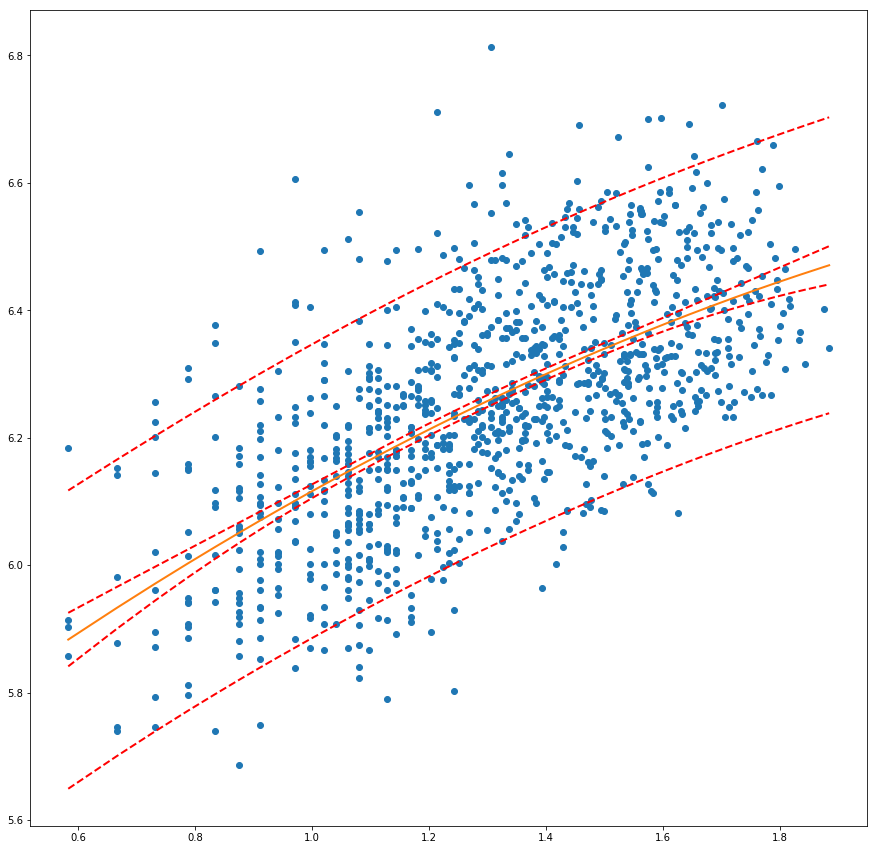

In [78]:
st, data, ss2 = summary_table(results, alpha=0.1)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T

plt.figure(figsize = (15,15))
plt.plot(df1['A16'], df1['A11'], 'o')
lists = np.array(sorted(zip(*[df1['A16'], fittedvalues])))
new_x, new_y = lists[:,0], lists[:,1]
plt.plot(new_x, new_y, '-', lw=2)

lists = np.array(sorted(zip(*[df1['A16'], predict_ci_low])))
new_x, new_y = lists[:,0], lists[:,1]
plt.plot(new_x, new_y, 'r--', lw=2)

lists = np.array(sorted(zip(*[df1['A16'], predict_ci_upp])))
new_x, new_y = lists[:,0], lists[:,1]
plt.plot(new_x, new_y, 'r--', lw=2)

lists = np.array(sorted(zip(*[df1['A16'], predict_mean_ci_low])))
new_x, new_y = lists[:,0], lists[:,1]
plt.plot(new_x, new_y, 'r--', lw=2)

lists = np.array(sorted(zip(*[df1['A16'], predict_mean_ci_upp])))
new_x, new_y = lists[:,0], lists[:,1]
plt.plot(new_x, new_y, 'r--', lw=2)

plt.show()

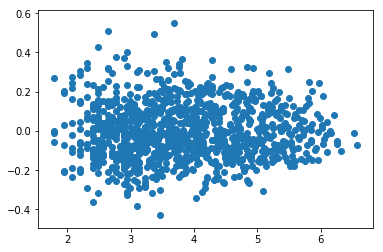

In [20]:
plt.scatter(df1['A16'], df1['A11'] - results.predict(sm.add_constant(df1[['A16', 'A16st2']])))

(array([ 38., 201., 320., 266., 145.,  71.,  23.,   7.,   1.,   1.]),
 array([-180.48869952, -122.27199372,  -64.05528791,   -5.8385821 ,
          52.37812371,  110.59482952,  168.81153532,  227.02824113,
         285.24494694,  343.46165275,  401.67835856]),
 <a list of 10 Patch objects>)

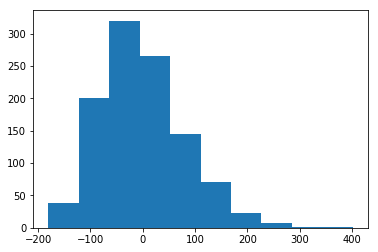

In [94]:
plt.hist(df1['A11'] - results.predict(sm.add_constant(df1[['A16', 'A16st2']])))

# 9.3

In [ ]:
df1['A6'] = np.log(df1['A6'])

In [33]:
model = sm.OLS(df1['A11'], sm.add_constant(df1[['A6st', 'A16st']]))
results = model.fit()

In [29]:
df1[['A6', 'A16']].describe()

,A6,A16
count,1073.000000,1073.000000
mean,6.026278,3.841366
std,0.168557,0.994232
min,5.455321,1.791759
25%,5.916202,3.044522
50%,6.033086,3.761200
75%,6.144186,4.615121
max,6.597146,6.580639


In [32]:
df1['A6st'] = (df1['A6'] - np.mean(df1['A6']))/np.std(df1['A6'])
df1['A16st'] = (df1['A16'] - np.mean(df1['A16']))/np.std(df1['A16'])

In [34]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    A11   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 1.386e+04
Date:                Mon, 09 Dec 2019   Prob (F-statistic):               0.00
Time:                        22:32:00   Log-Likelihood:                 2072.7
No. Observations:                1073   AIC:                            -4139.
Df Residuals:                    1070   BIC:                            -4124.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.2541      0.001   5834.479      0.0

In [36]:
from sklearn.linear_model import Lasso

In [44]:
clf = Lasso(alpha=100)
clf.fit(df1[['A6', 'A16']], df1['A11'])

Lasso(alpha=100, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [45]:
clf.score(df1[['A6st', 'A16st']], df1['A11'])

0.0

In [43]:
clf.coef_

array([0., 0.])

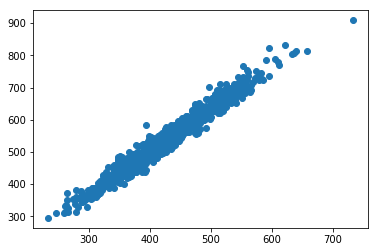

In [26]:
plt.scatter(df1['A6'], df1['A11'])

In [15]:
results.rsquared

0.9636360539340022

In [18]:
stats.pearsonr(df1['A16'], df1['A6'])

(0.47656047855218564, 6.230379100352977e-62)

In [35]:
np.sqrt(results.rsquared)

0.9815209145552884

In [36]:
stats.pearsonr(df1['A11'], df1['A6'])

(0.9815209145552882, 0.0)

In [38]:
regr_analyses_tab(results)

array([[8.78164746e+03, 1.00000000e+00, 9.42270772e+06],
       [3.33776700e+02, 1.07100000e+03, 3.34399999e+02],
       [9.11542416e+03, 1.07200000e+03, 9.12392735e+03]])